### MNIST Image classification using MLP
The original code was taken from kaggle with some changes and improved with ChatGPT to use Adam Optimizer (originally optimization function was Gradient Descent) and to make it more dynamic (additional layers can be added to increase accuracy, beware of overfitting though).

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [24]:
data = pd.read_csv('train.csv')
data.head()
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [25]:
class NeuralNetwork:
    def __init__(self, layer_dims):
        self.parameters = {}
        self.L = len(layer_dims)  # number of layers in the network
        self.m = None  # will be set during training
        self.layer_dims = layer_dims
        self.v = {}
        self.s = {}
        
        # Initialize parameters and Adam variables
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            self.parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
            
            self.v["dW" + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            self.v["db" + str(l)] = np.zeros((layer_dims[l], 1))
            
            self.s["dW" + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            self.s["db" + str(l)] = np.zeros((layer_dims[l], 1))
    
    @staticmethod
    def ReLU(Z):
        return np.maximum(Z, 0)
    
    @staticmethod
    def softmax(Z):
        expZ = np.exp(Z - np.max(Z))  # for numerical stability
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    @staticmethod
    def ReLU_deriv(Z):
        return Z > 0
    
    @staticmethod
    def one_hot(Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def forward_prop(self, X):
        caches = {}
        A = X
        caches["A0"] = X
        
        # ReLU activations for layers 1 to L-1
        for l in range(1, self.L-1):
            Z = self.parameters["W" + str(l)].dot(A) + self.parameters["b" + str(l)]
            A = self.ReLU(Z)
            caches["A" + str(l)] = A
            caches["Z" + str(l)] = Z
        
        # Softmax activation for the last layer
        ZL = self.parameters["W" + str(self.L-1)].dot(A) + self.parameters["b" + str(self.L-1)]
        AL = self.softmax(ZL)
        caches["A" + str(self.L-1)] = AL
        caches["Z" + str(self.L-1)] = ZL
        
        return AL, caches
    
    def backward_prop(self, AL, Y, caches):
        grads = {}
        one_hot_Y = self.one_hot(Y)
        
        # Starting the backpropagation
        dZ = AL - one_hot_Y
        grads["dW" + str(self.L-1)] = 1/self.m * dZ.dot(caches["A" + str(self.L-2)].T)
        grads["db" + str(self.L-1)] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
        
        for l in reversed(range(1, self.L-1)):
            dZ_next = dZ
            dZ = self.parameters["W" + str(l+1)].T.dot(dZ_next) * self.ReLU_deriv(caches["Z" + str(l)])
            grads["dW" + str(l)] = 1/self.m * dZ.dot(caches["A" + str(l-1)].T)
            grads["db" + str(l)] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
        
        return grads
    
    def update_params_with_adam(self, grads, alpha, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        for l in range(1, self.L):
            # Moving average of the gradients
            self.v["dW" + str(l)] = beta1 * self.v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
            self.v["db" + str(l)] = beta1 * self.v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]
            
            # Compute bias-corrected first moment estimate
            v_corrected_dW = self.v["dW" + str(l)] / (1 - beta1**t)
            v_corrected_db = self.v["db" + str(l)] / (1 - beta1**t)
            
            # Moving average of the squared gradients
            self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)]**2)
            self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)]**2)
            
            # Compute bias-corrected second raw moment estimate
            s_corrected_dW = self.s["dW" + str(l)] / (1 - beta2**t)
            s_corrected_db = self.s["db" + str(l)] / (1 - beta2**t)
            
            # Update parameters
            self.parameters["W" + str(l)] -= alpha * v_corrected_dW / (np.sqrt(s_corrected_dW) + epsilon)
            self.parameters["b" + str(l)] -= alpha * v_corrected_db / (np.sqrt(s_corrected_db) + epsilon)
    
    def train(self, X, Y, alpha, iterations):
        self.m = X.shape[1]
        
        for i in range(1, iterations+1):
            AL, caches = self.forward_prop(X)
            grads = self.backward_prop(AL, Y, caches)
            self.update_params_with_adam(grads, alpha, i)
            
            if i % 20 == 0:
                predictions = self.get_predictions(AL)
                accuracy = self.get_accuracy(predictions, Y)
                print(f"Iteration {i} - Accuracy: {accuracy}")
    
    @staticmethod
    def get_predictions(A):
        return np.argmax(A, axis=0)
    
    @staticmethod
    def get_accuracy(predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def make_predictions(self, X):
        AL, _ = self.forward_prop(X)
        predictions = self.get_predictions(AL)
        return predictions

    def compute_accuracy(self, X, Y):
        predictions = self.make_predictions(X)
        return self.get_accuracy(predictions, Y)
    def compute_loss(self, AL, Y):
        """
        Compute the cross-entropy loss.
        
        Parameters:
        - AL: Activations from the last layer, representing probability vector corresponding to label predictions.
        - Y: True labels vector.
        
        Returns:
        - Cross-entropy loss.
        """
        one_hot_Y = self.one_hot(Y)
        m = Y.size
        loss = -1/m * np.sum(one_hot_Y * np.log(AL + 1e-8))  # adding a small value to avoid log(0)
        return loss
    def compute_loss_on_dataset(self, X, Y):
        """
        Compute the loss on a given dataset.
        
        Parameters:
        - X: Input data.
        - Y: True labels vector.
        
        Returns:
        - Cross-entropy loss.
        """
        AL, _ = self.forward_prop(X)
        return self.compute_loss(AL, Y)
    
def test_prediction(index, model):
    current_image = X_train[:, index, None]
    prediction = model.make_predictions(current_image)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()



In [26]:
nn = NeuralNetwork([784, 128, 128, 10])
nn.train(X_train, Y_train, alpha=0.001, iterations=201) 

Iteration 20 - Accuracy: 0.5396341463414634
Iteration 40 - Accuracy: 0.782219512195122
Iteration 60 - Accuracy: 0.8672439024390244
Iteration 80 - Accuracy: 0.8977560975609756
Iteration 100 - Accuracy: 0.9124634146341464
Iteration 120 - Accuracy: 0.9236585365853659
Iteration 140 - Accuracy: 0.9318780487804879
Iteration 160 - Accuracy: 0.9394634146341463
Iteration 180 - Accuracy: 0.9463170731707317
Iteration 200 - Accuracy: 0.9527560975609756


Prediction:  [0]
Label:  0


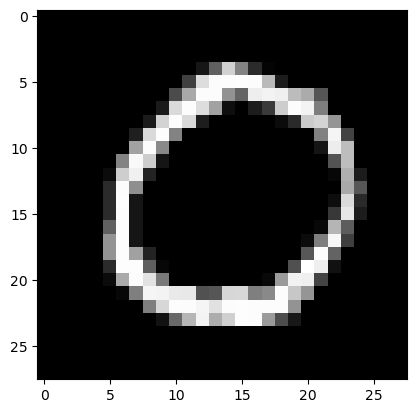

In [27]:
test_prediction(6, nn)  # Test prediction for the 6th example in the training set

In [28]:
test_accuracy = nn.compute_accuracy(X_dev, Y_dev)
print(f"Accuracy on test dataset: {test_accuracy * 100:.2f}%")
test_loss = nn.compute_loss_on_dataset(X_dev, Y_dev)
print(f"Loss on test dataset: {test_loss *100:.2f}%")

Accuracy on test dataset: 93.30%
Loss on test dataset: 19.00%
